In [8]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import joblib
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Make WordCloud optional
try:
    from wordcloud import WordCloud
except ImportError:
    WordCloud = None

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score



In [9]:
# ==========================================
# 1️⃣ CONFIGURATION & INIT
# ==========================================
print("📥 Initialisation des outils NLP...")
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Configuration Graphique
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


📥 Initialisation des outils NLP...


In [10]:

# ==========================================
# 2️⃣ PREPROCESSING AVANCÉ
# ==========================================
class EmailPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words("english"))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        if not isinstance(text, str): return ""
        text = text.lower()
        # Retrait des URLs (gardées ailleurs comme feature)
        text = re.sub(r"http\S+|www\S+|https\S+", "", text)
        # Garder uniquement les caractères alphanumériques
        text = re.sub(r"[^a-z\s]", " ", text)
        text = re.sub(r"\s+", " ", text).strip()
        return text

    def tokenize_and_lemmatize(self, text):
        tokens = text.split()
        # Filtrage (Stopwords + mots courts) et Lemmatisation
        tokens = [self.lemmatizer.lemmatize(t) for t in tokens if t not in self.stop_words and len(t) > 2]
        return " ".join(tokens)

    def preprocess(self, text):
        cleaned = self.clean_text(text)
        return self.tokenize_and_lemmatize(cleaned)



In [11]:
# ==========================================
# 3️⃣ FEATURE ENGINEERING (Header & Stats)
# ==========================================
def extract_features(df):
    print("🛠️ Extraction des Features (Headers & Statistiques)...")
    
    # A. Headers Regex Extraction (Robust to spaces like 'from :')
    def get_header_from_text(text, field):
        # Cherche "Field: Value" ou "Field : Value"
        match = re.search(rf"{field}\s*:(.*)", str(text), re.IGNORECASE)
        return match.group(1).strip() if match else "unknown"

    # Si la colonne 'subject' existe déjà, on l'utilise directement, sinon on tente l'extraction
    if 'subject' not in df.columns:
        df['subject'] = df['message'].apply(lambda x: get_header_from_text(x, "Subject"))
    else:
        # Nettoyage basique du sujet existant
        df['subject'] = df['subject'].fillna("unknown").astype(str)

    # Extraction de l'expéditeur depuis le corps du message (si présent dans les forwards)
    df['from_'] = df['message'].apply(lambda x: get_header_from_text(x, "From"))
    
    # B. Features Statistiques
    suspicious_words = ["urgent", "verify", "account", "update", "bank", "suspend", "click", "password", "security", "login"]
    
    df['url_count'] = df['message'].apply(lambda x: len(re.findall(r"http\S+|www\S+", str(x))))
    df['susp_word_count'] = df['message'].apply(lambda x: sum(str(x).lower().count(w) for w in suspicious_words))
    df['text_len'] = df['message'].apply(lambda x: len(str(x)))
    df['caps_ratio'] = df['message'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0)

    return df



In [12]:
# ==========================================
# 4️⃣ ANALYSE EXPLORATOIRE (EDA)
# ==========================================
def perform_eda(df):
    print("\n📊 --- ANALYSE EXPLORATOIRE (EDA) ---")
    
    # 1. Distribution des labels
    plt.figure(figsize=(8, 5))
    sns.countplot(x='label', data=df, palette='coolwarm')
    plt.title("Distribution des Classes (0=Legit, 1=Phishing)")
    plt.show()

    # 2. Longueur du texte par classe
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=df, x='text_len', hue='label', fill=True, palette='coolwarm', common_norm=False)
    plt.xlim(0, 5000) 
    plt.title("Distribution de la longueur des emails")
    plt.show()

    # 3. Features numériques (Boxplots)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.boxplot(x='label', y='url_count', data=df, ax=axes[0], palette='coolwarm', showfliers=False)
    axes[0].set_title("Nombre d'URLs par classe")
    
    sns.boxplot(x='label', y='susp_word_count', data=df, ax=axes[1], palette='coolwarm', showfliers=False)
    axes[1].set_title("Mots suspects par classe")
    plt.show()

    # 4. WordCloud Phishing
    if WordCloud is not None:
        print("☁️ Génération du WordCloud pour le Phishing...")
        phishing_text = " ".join(df[df['label'] == 1]['processed_body'].astype(str))
        if len(phishing_text) > 0:
            wc = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(phishing_text)
            plt.figure(figsize=(12, 6))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title("Mots clés du Phishing")
            plt.show()
    else:
        print("\n⚠️ Note: Module 'wordcloud' introuvable. Ignoré.")



In [13]:
# ==========================================
# 5️⃣ ANALYSE DES RÉSULTATS
# ==========================================
def analyze_model_results(model, X_test, y_test, model_name):
    print(f"\n🔬 --- ANALYSE DÉTAILLÉE : {model_name} ---")
    
    y_pred = model.predict(X_test)
    
    # A. Matrice de Confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Legit', 'Phishing'], yticklabels=['Legit', 'Phishing'])
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()

    # B. Rapport
    print(classification_report(y_test, y_pred, target_names=['Legit', 'Phishing']))

    # C. Feature Importance (pour SVM/Logistic)
    try:
        classifier = model.named_steps['classifier']
        preprocessor = model.named_steps['preprocessor']
        
        # Accès au vocabulaire TF-IDF
        tfidf = preprocessor.named_transformers_['tfidf']
        feature_names = tfidf.get_feature_names_out()
        
        if hasattr(classifier, 'coef_'):
            coefs = classifier.coef_.flatten()
            # On prend seulement les coefs correspondant au TF-IDF
            # Note: Approximatif si OneHotEncoder ajoute beaucoup de colonnes
            top_indices = np.argsort(coefs[-len(feature_names):])[-20:]
            top_words = [feature_names[i] for i in top_indices]
            
            print(f"\n🔑 Top 20 Mots Indicateurs de Phishing ({model_name}):")
            print(", ".join(top_words))
            
            plt.figure(figsize=(10, 6))
            plt.barh(top_words, coefs[-len(feature_names):][top_indices], color='red')
            plt.title(f"Impact des mots sur la décision Phishing ({model_name})")
            plt.show()
            
    except Exception as e:
        print(f"⚠️ Feature importance non dispo: {e}")



📂 Chargement de C:\Users\khaol\OneDrive\Desktop\Phishing-Email-Detection\data\raw\Enron.csv...
   Colonnes originales : ['subject', 'body', 'label']
🔄 Fusion Subject + Body pour analyse...
🛠️ Extraction des Features (Headers & Statistiques)...
🧹 Tokenization & Lemmatization...

📊 --- ANALYSE EXPLORATOIRE (EDA) ---


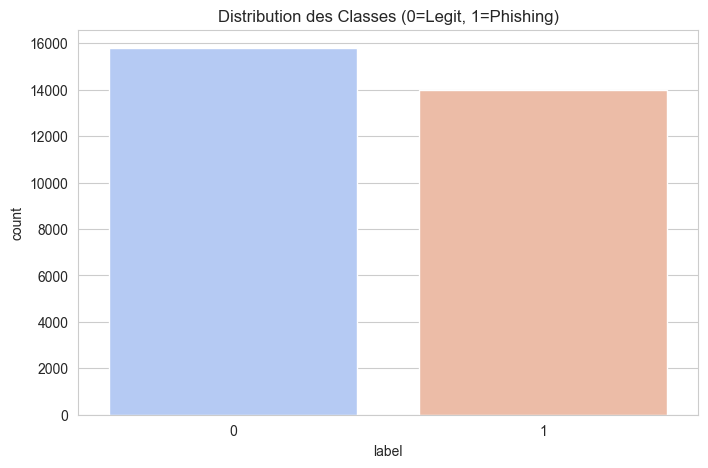

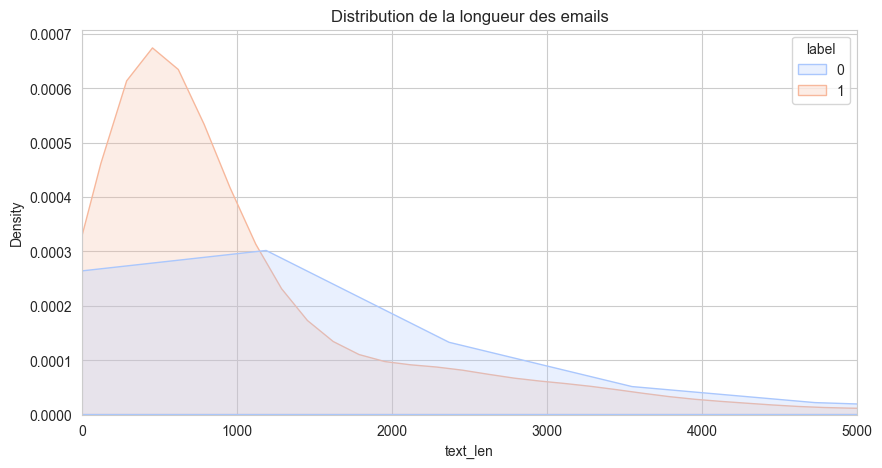

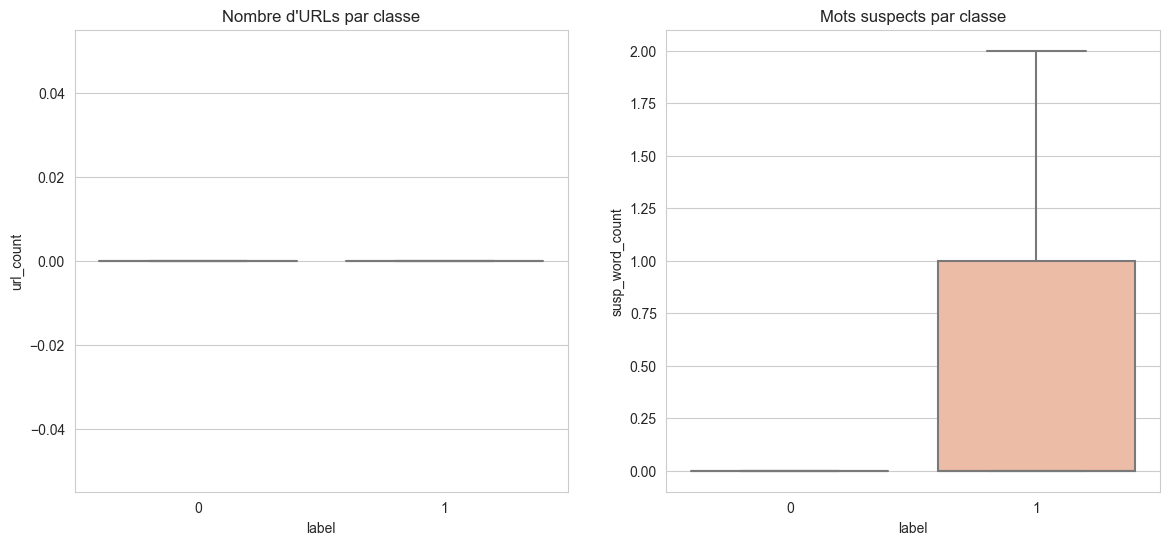

☁️ Génération du WordCloud pour le Phishing...


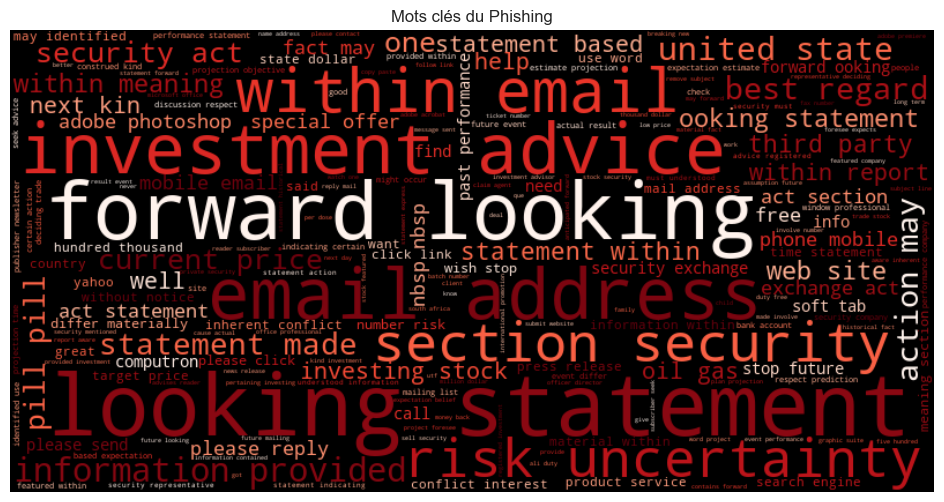


⚔️ --- COMPARAISON DES MODÈLES ---
Training LinearSVC...
   ✅ LinearSVC F1-Score: 0.9861
Training RandomForest...
   ✅ RandomForest F1-Score: 0.9797
Training LogisticRegression...
   ✅ LogisticRegression F1-Score: 0.9809

🏆 MEILLEUR MODÈLE : LinearSVC (F1: 0.9861)

🔬 --- ANALYSE DÉTAILLÉE : LinearSVC ---


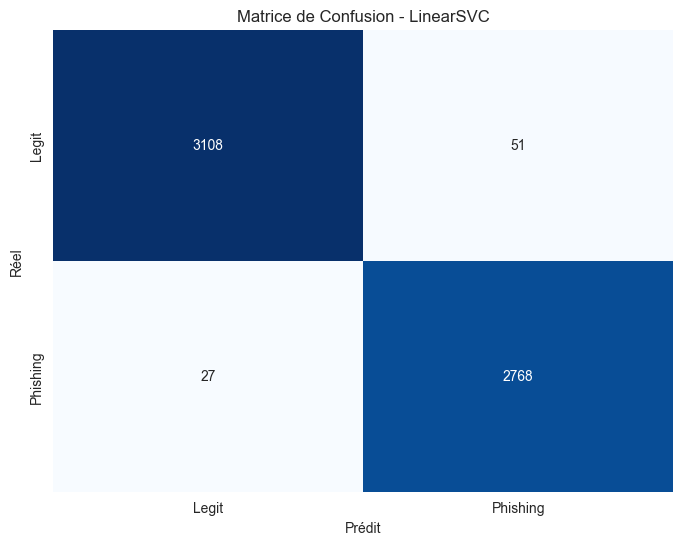

              precision    recall  f1-score   support

       Legit       0.99      0.98      0.99      3159
    Phishing       0.98      0.99      0.99      2795

    accuracy                           0.99      5954
   macro avg       0.99      0.99      0.99      5954
weighted avg       0.99      0.99      0.99      5954


🔑 Top 20 Mots Indicateurs de Phishing (LinearSVC):
lannou hou, lavorato, france, http, reason, official, enjoy, energy derivative, parsing, spoken, megawatt, get back, reliance, resellers, john martin, melissa jones, facilitate, find, replica, please advise


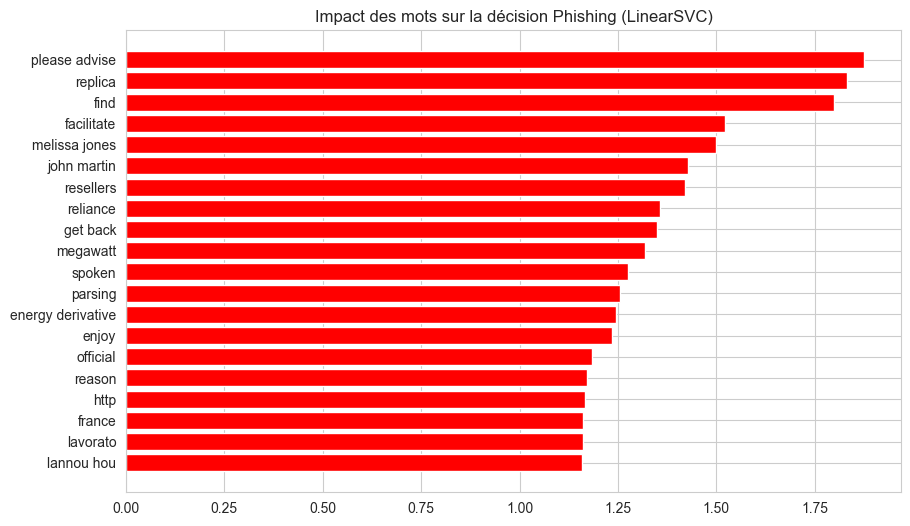


💾 Modèle sauvegardé : best_phishing_model.pkl


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

# ==========================================
# 6️⃣ MAIN PIPELINE
# ==========================================
def main():

    # --------------------------------------
    # 1️⃣ Compute PROJECT ROOT automatically
    # --------------------------------------
    project_root = os.path.dirname(os.path.abspath(__file__))

    # dataset →   /data/raw/Enron.csv
    dataset_path = os.path.join(project_root, "data", "raw", "Enron.csv")

    models_dir = os.path.join(project_root, "models")

    # Création du dossier models si inexistant
    os.makedirs(models_dir, exist_ok=True)

    print(f"📂 Chargement dataset depuis : {dataset_path}")

    try:
        df = pd.read_csv(dataset_path, low_memory=False)
        print("  Dataset chargé")
    except Exception as e:
        print(f" Erreur: impossible de lire le CSV : {e}")
        return

    print(f"   Colonnes originales : {df.columns.tolist()}")

    # 2. NORMALISATION
    df.columns = [c.lower().strip() for c in df.columns]
    
    if 'content' in df.columns: df.rename(columns={'content': 'body'}, inplace=True)
    if 'text' in df.columns: df.rename(columns={'text': 'body'}, inplace=True)
    if 'class' in df.columns: df.rename(columns={'class': 'label'}, inplace=True)
    if 'spam' in df.columns: df.rename(columns={'spam': 'label'}, inplace=True)

    required = ['body', 'label']
    missing = [c for c in required if c not in df.columns]
    if missing:
        print(f" Colonnes manquantes : {missing}")
        return

    # --------------------------------------
    # 3️⃣ Fusion subject + body
    # --------------------------------------
    print(" Fusion Subject + Body...")
    if 'subject' in df.columns:
        df['message'] = df['subject'].fillna("") + " " + df['body'].fillna("")
    else:
        df['message'] = df['body'].fillna("")

    # --------------------------------------
    # 4️⃣ Extraire & Preprocess
    # --------------------------------------
    df = extract_features(df)
    preprocessor = EmailPreprocessor()
    df['processed_body'] = df['message'].apply(preprocessor.preprocess_email)

    # --------------------------------------
    # 5️⃣ Préparation
    # --------------------------------------
    features = ['processed_body', 'from_', 'subject', 'url_count', 'susp_word_count', 'caps_ratio']
    X = df[features]
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # --------------------------------------
    # 6️⃣ ColumnTransformer
    # --------------------------------------
    column_transformer = ColumnTransformer(
        transformers=[
            ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2)), 'processed_body'),
            ('from_enc', OneHotEncoder(handle_unknown='ignore'), ['from_']),
            ('subj_enc', OneHotEncoder(handle_unknown='ignore'), ['subject']),
            ('num_scaler', StandardScaler(), ['url_count', 'susp_word_count', 'caps_ratio'])
        ]
    )

    # --------------------------------------
    # 7️⃣ Training models
    # --------------------------------------
    models = {
        "LinearSVC": LinearSVC(random_state=42, dual="auto"),
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42)
    }

    best_score = 0
    best_model = None
    best_name = ""

    print("\n COMPARAISON DES MODÈLES")
    for name, clf in models.items():
        print(f"\nTraining {name}...")
        pipeline = Pipeline([
            ('preprocessor', column_transformer),
            ('classifier', clf)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        score = f1_score(y_test, y_pred)

        print(f"   {name} → F1 = {score:.4f}")

        if score > best_score:
            best_score = score
            best_model = pipeline
            best_name = name

    print(f"\n🏆 MEILLEUR MODÈLE = {best_name} (F1={best_score:.4f})")

    # --------------------------------------
    # 8️⃣ SAVE MODEL (with os.path)
    # --------------------------------------
    save_path = os.path.join(models_dir, f"{best_name}_model.pkl")
    joblib.dump(best_model, save_path)

    print(f"\n💾 Modèle sauvegardé ici : {save_path}\n")

if __name__ == "__main__":
    main()


In [17]:
# ==========================================
# 2. FONCTION DE PRÉPARATION (Raw Email -> DataFrame)
# ==========================================
def prepare_email_for_model(raw_email):
    # A. Extraction des Headers via Regex
    def get_header(text, field):
        match = re.search(rf"{field}\s*:(.*)", text, re.IGNORECASE)
        return match.group(1).strip() if match else "unknown"

    # B. Séparation Header / Body (souvent séparés par une ligne vide)
    try:
        parts = raw_email.split("\n\n", 1)
        body = parts[1] if len(parts) > 1 else raw_email
    except:
        body = raw_email

    subj = get_header(raw_email, "Subject")
    from_ = get_header(raw_email, "From")
    
    # C. Construction du message combiné pour le NLP (Subject + Body)
    message_combined = f"{subj} {body}"
    
    # D. Calcul des Features Statistiques (doit correspondre exactement aux colonnes d'entraînement)
    suspicious_words = ["urgent", "verify", "account", "update", "bank", "suspend", "click", "password", "security", "login"]
    
    url_count = len(re.findall(r"http\S+|www\S+", raw_email))
    susp_word_count = sum(raw_email.lower().count(w) for w in suspicious_words)
    # Ratio de majuscules
    caps_ratio = sum(1 for c in raw_email if c.isupper()) / len(raw_email) if len(raw_email) > 0 else 0
    
    # E. NLP Preprocessing
    preprocessor = EmailPreprocessor()
    processed_body = preprocessor.preprocess(message_combined)

    # F. Création du DataFrame (Ordre EXACT des colonnes utilisées dans X lors du fit)
    # X = df[['processed_body', 'from_', 'subject', 'url_count', 'susp_word_count', 'caps_ratio']]
    df_input = pd.DataFrame([{
        'processed_body': processed_body,
        'from_': from_,
        'subject': subj,
        'url_count': url_count,
        'susp_word_count': susp_word_count,
        'caps_ratio': caps_ratio
    }])
    
    return df_input

# ==========================================
# 3. TEST DU MODÈLE
# ==========================================

# 📧 EXEMPLE 1 : Phishing (PayPal Scam)
email_phishing = """From: security@paypal-verification-alert.com
Subject: URGENT: Unusual Login Attempt Detected
To: user@example.com

Dear Customer,

We detected a login from an unknown device in Russia. 
To protect your funds, we have limited your account access.

Please click the link below to verify your identity immediately:
http://bit.ly/secure-paypal-login

If you do not act within 24 hours, your account will be permanently suspended.

Sincerely,
PayPal Security Team
"""

# 📧 EXEMPLE 2 : Legitimate (Enron Style)
email_legit = """From: vince.kaminski@enron.com
Subject: Re: Risk Management Meeting
To: shirley.crenshaw@enron.com

Hi Shirley,

Can we reschedule the team meeting to Friday at 2 PM? 
I have to review the quarterly gas trading reports on Thursday.

Let me know if the conference room is available.

Thanks,
Vince
"""

# Chargement et Prédiction
model_filename = "best_phishing_model.pkl"

print(f"🔄 Chargement du modèle '{model_filename}'...\n")

try:
    loaded_model = joblib.load(model_filename)
    print("✅ Modèle chargé avec succès !\n")
    print("-" * 50)

    emails_to_test = [("🚨 TEST PHISHING", email_phishing), ("✅ TEST LEGIT", email_legit)]

    for label_test, email_text in emails_to_test:
        print(f"Analyse de : {label_test}")
        
        # 1. Préparation
        input_data = prepare_email_for_model(email_text)
        
        # 2. Prédiction
        prediction = loaded_model.predict(input_data)[0]
        
        # 3. Affichage
        result = "PHISHING DETECTÉ" if prediction == 1 else "EMAIL LÉGITIME"
        print(f"Sujet      : {input_data['subject'][0]}")
        print(f"Expéditeur : {input_data['from_'][0]}")
        print(f"Résultat   : {result}")
        print("-" * 50)

except FileNotFoundError:
    print(f"❌ Erreur : Le fichier '{model_filename}' est introuvable.")
    print("   Vérifiez que vous avez bien exécuté le script d'entraînement (complete_phishing_pipeline.py) avant.")
except Exception as e:
    print(f"❌ Une erreur est survenue : {e}")

🔄 Chargement du modèle 'best_phishing_model.pkl'...

✅ Modèle chargé avec succès !

--------------------------------------------------
Analyse de : 🚨 TEST PHISHING
Sujet      : URGENT: Unusual Login Attempt Detected
Expéditeur : security@paypal-verification-alert.com
Résultat   : PHISHING DETECTÉ
--------------------------------------------------
Analyse de : ✅ TEST LEGIT
Sujet      : Re: Risk Management Meeting
Expéditeur : vince.kaminski@enron.com
Résultat   : EMAIL LÉGITIME
--------------------------------------------------
